## Import all involved packages

In [227]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV as gsv
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV as rsv
from sklearn.metrics import classification_report

In [228]:
df = pd.read_csv("kickstarter_projects.csv")
df = df.drop(columns='ID')
df.head()

Name      Category  \
0  Grace Jones Does Not Give A F$#% T-Shirt (limi...       Fashion   
1                     CRYSTAL ANTLERS UNTITLED MOVIE  Film & Video   
2                                drawing for dollars           Art   
3                       Offline Wikipedia iPhone app    Technology   
4                                         Pantshirts       Fashion   

    Subcategory        Country             Launched    Deadline   Goal  \
0       Fashion  United States  2009-04-21 21:02:48  2009-05-31   1000   
1        Shorts  United States  2009-04-23 00:07:53  2009-07-20  80000   
2  Illustration  United States  2009-04-24 21:52:03  2009-05-03     20   
3      Software  United States  2009-04-25 17:36:21  2009-07-14     99   
4       Fashion  United States  2009-04-27 14:10:39  2009-05-26   1900   

   Pledged  Backers       State  
0      625       30      Failed  
1       22        3      Failed  
2       35        3  Successful  
3      145       25  Successful  
4      387       10      Failed

## Data cleansing & preparation

In [229]:
df.isnull().any() # To test is Null exist on DataFrame, No null presents

Name           False
Category       False
Subcategory    False
Country        False
Launched       False
Deadline       False
Goal           False
Pledged        False
Backers        False
State          False
dtype: bool

In [230]:
df.shape # There is 374853 rows and 10 columns from the dataset

(374853, 10)

In [231]:
df.info() # see the data type of each columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374853 entries, 0 to 374852
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Name         374853 non-null  object
 1   Category     374853 non-null  object
 2   Subcategory  374853 non-null  object
 3   Country      374853 non-null  object
 4   Launched     374853 non-null  object
 5   Deadline     374853 non-null  object
 6   Goal         374853 non-null  int64 
 7   Pledged      374853 non-null  int64 
 8   Backers      374853 non-null  int64 
 9   State        374853 non-null  object
dtypes: int64(3), object(7)
memory usage: 28.6+ MB


In [232]:
pd.crosstab(index=df["Category"], columns="count") 
# to see whether there are fragmentation in "Category"

col_0         count
Category           
Art           28151
Comics        10819
Crafts         8809
Dance          3767
Design        30065
Fashion       22812
Film & Video  62694
Food          24599
Games         35225
Journalism     4754
Music         49529
Photography   10778
Publishing    39378
Technology    32562
Theater       10911

In [233]:
pd.crosstab(index=df["Subcategory"], columns="count").sort_values("count")
# to see whether there are fragmentation in "Subcategory"
# Here the dataset is came from the website, which is not survey
# so the fragmentation would be rarely occured.

col_0            count
Subcategory           
Taxidermy           13
Literary Spaces     27
Chiptune            35
Letterpress         49
Residencies         69
...                ...
Shorts           12357
Music            13339
Tabletop Games   14178
Documentary      16138
Product Design   22310

[159 rows x 1 columns]

In [234]:
# convert Deadline & Launched to datetime for easier calculation
df["Deadline"] = pd.to_datetime(df["Deadline"])
df["Launched"] = pd.to_datetime(df["Launched"])

# Interval in days
df['Interval'] = (df['Deadline'] - df['Launched']).dt.days 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374853 entries, 0 to 374852
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Name         374853 non-null  object        
 1   Category     374853 non-null  object        
 2   Subcategory  374853 non-null  object        
 3   Country      374853 non-null  object        
 4   Launched     374853 non-null  datetime64[ns]
 5   Deadline     374853 non-null  datetime64[ns]
 6   Goal         374853 non-null  int64         
 7   Pledged      374853 non-null  int64         
 8   Backers      374853 non-null  int64         
 9   State        374853 non-null  object        
 10  Interval     374853 non-null  int64         
dtypes: datetime64[ns](2), int64(4), object(5)
memory usage: 31.5+ MB


## Data visualization for analysis

### Goal distribution between  each category

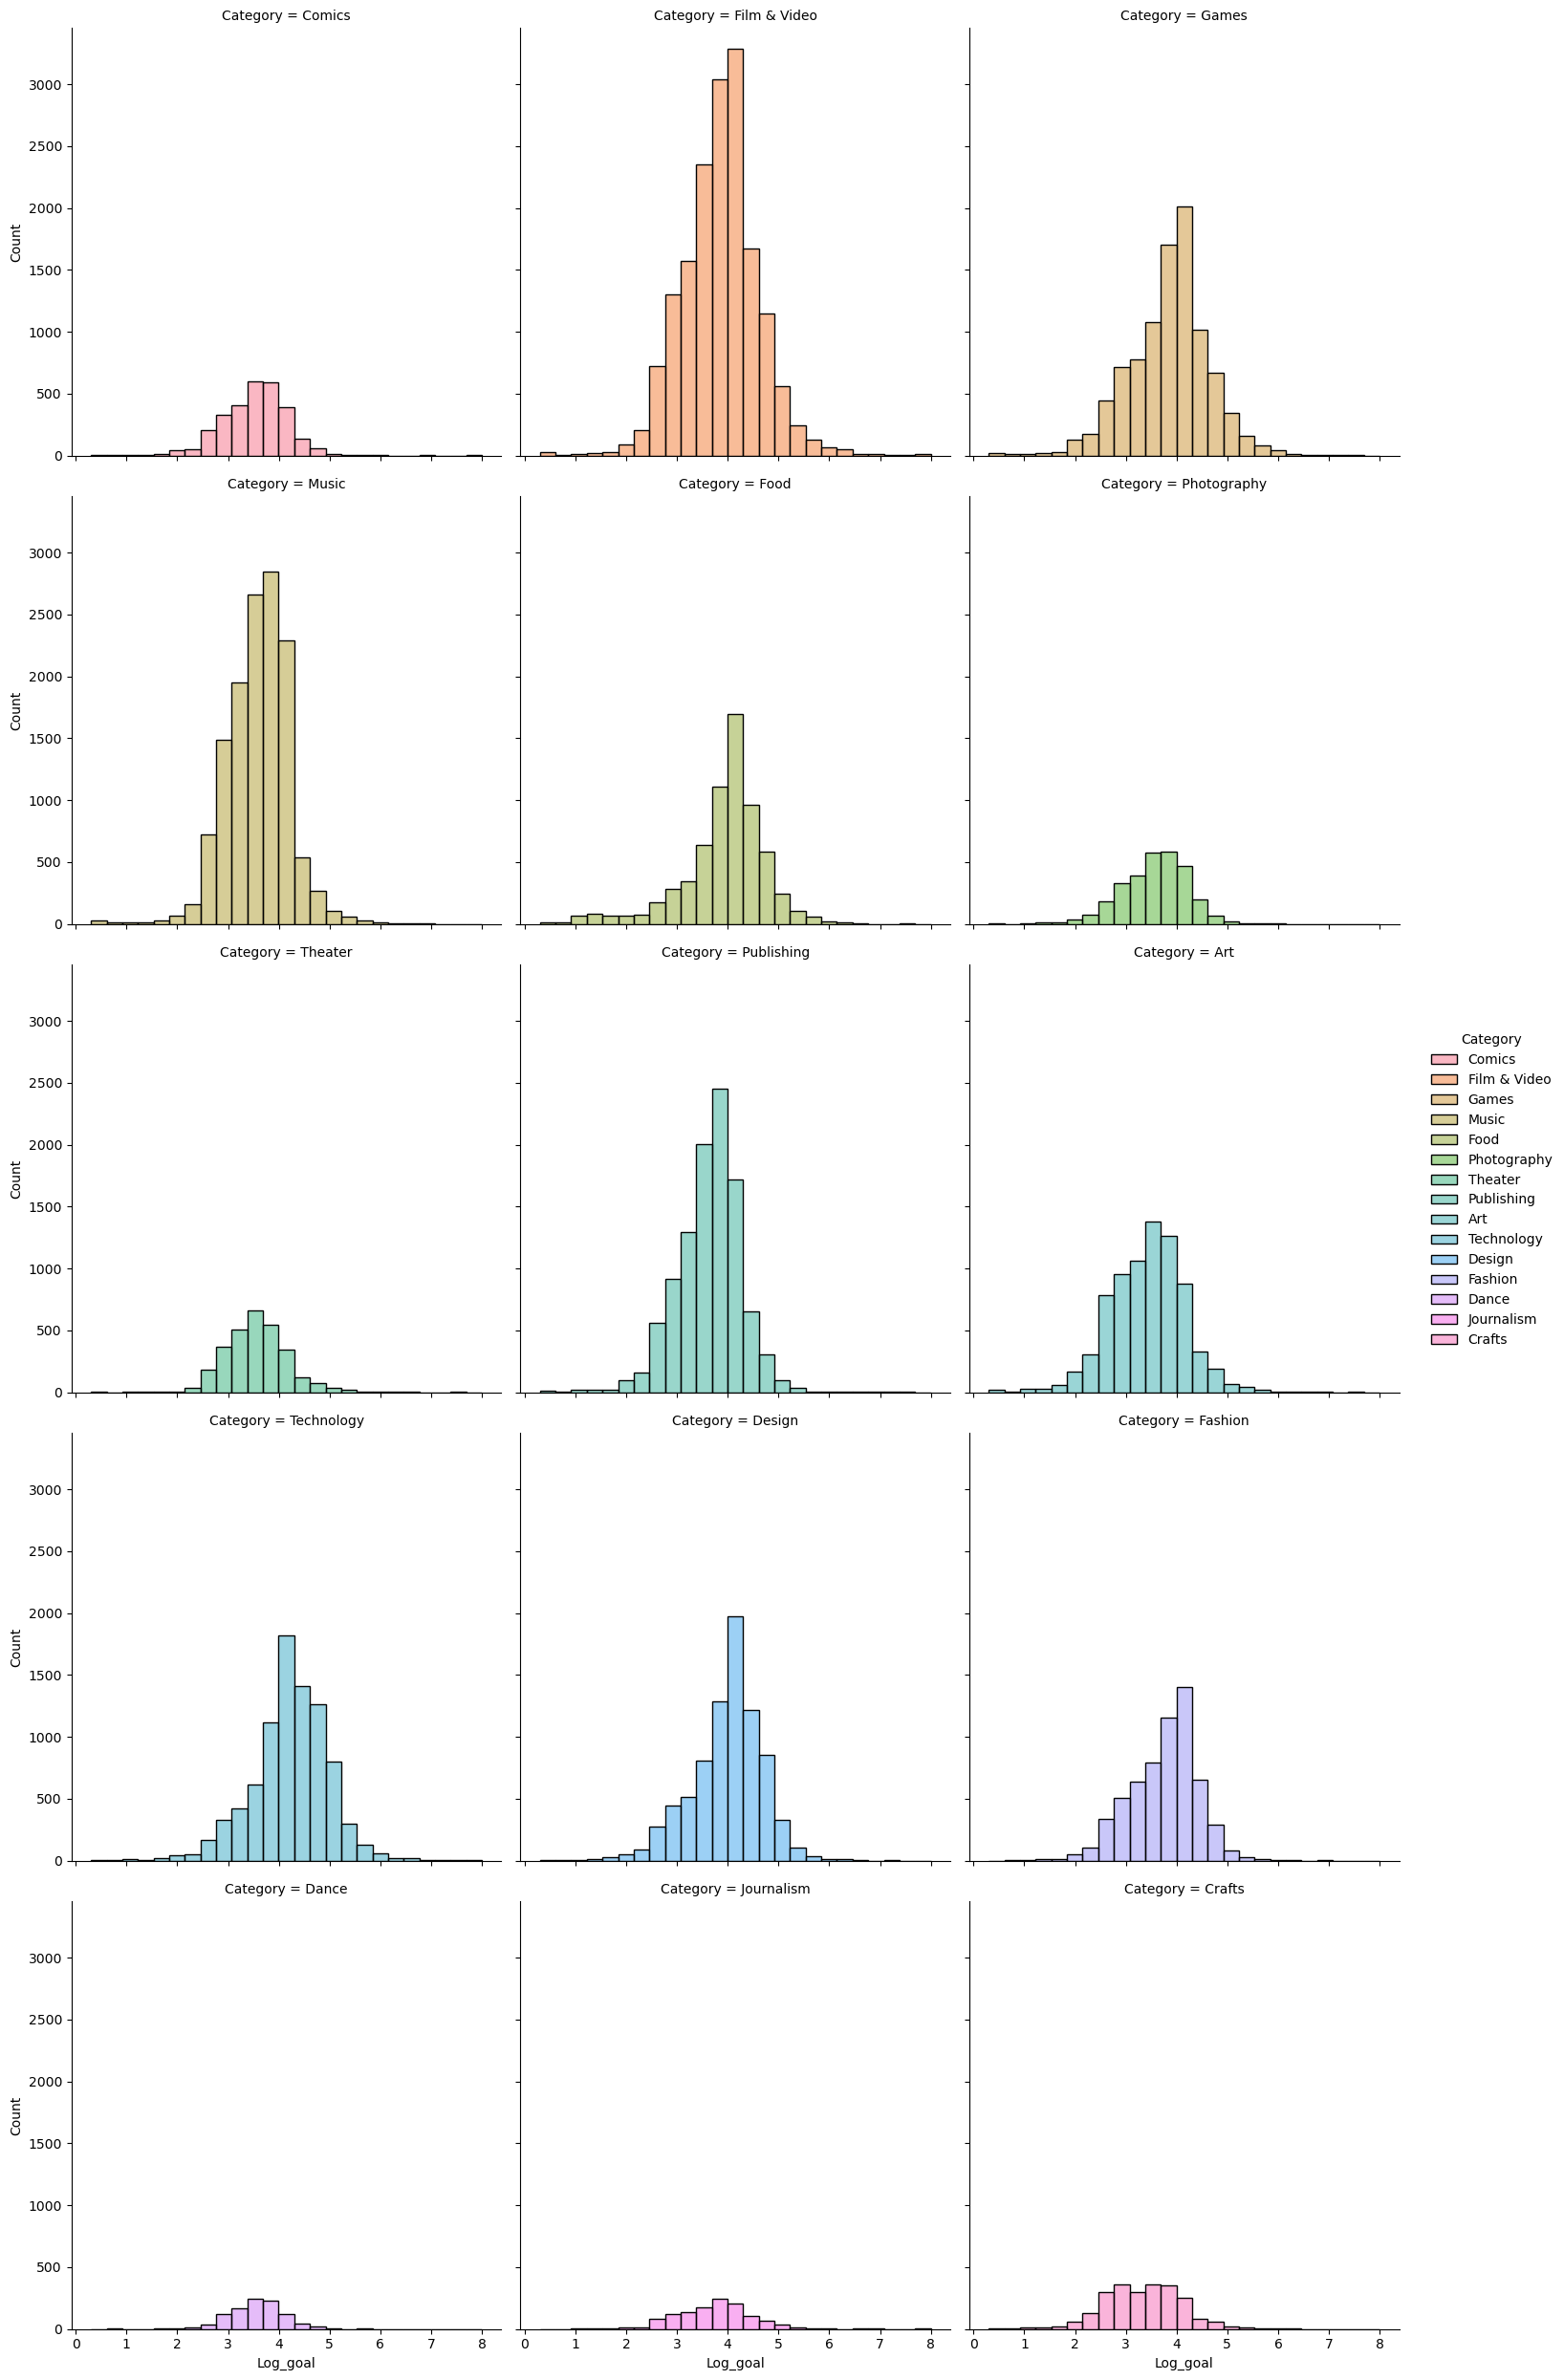

In [235]:
sample = df.sample(n=100000)
temp = sample.copy()

temp['Log_goal'] = np.log10(temp['Goal']+1)
sns.displot(data=temp,col='Category',col_wrap=3,x='Log_goal',bins=25,hue='Category')
plt.show()

### State distribution between country

In [236]:
temp = sample.copy()
temp['State/Country'] = 0
temp = temp.groupby(['Country','State'])['State/Country'].count().reset_index().sort_values('State/Country',ascending=False)
temp

Country       State  State/Country
103   United States      Failed          40454
105   United States  Successful          29312
102   United States    Canceled           7582
98   United Kingdom      Failed           4664
100  United Kingdom  Successful           3242
..              ...         ...            ...
9           Austria   Suspended              1
81        Singapore   Suspended              1
54       Luxembourg    Canceled              1
44          Ireland   Suspended              1
74           Norway        Live              1

[107 rows x 3 columns]

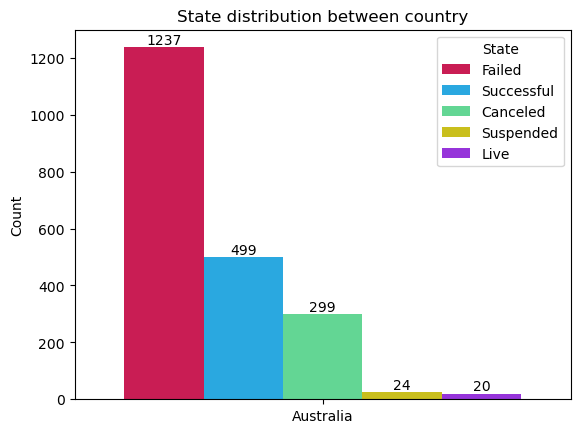

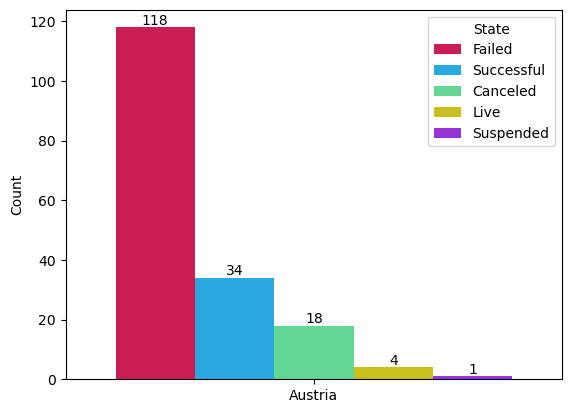

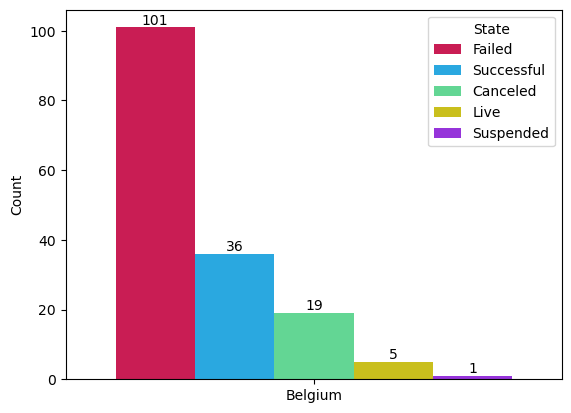

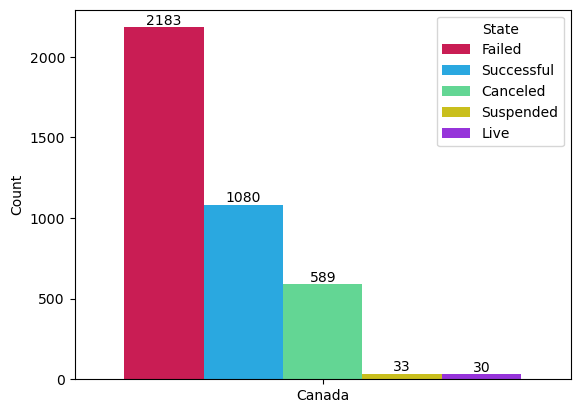

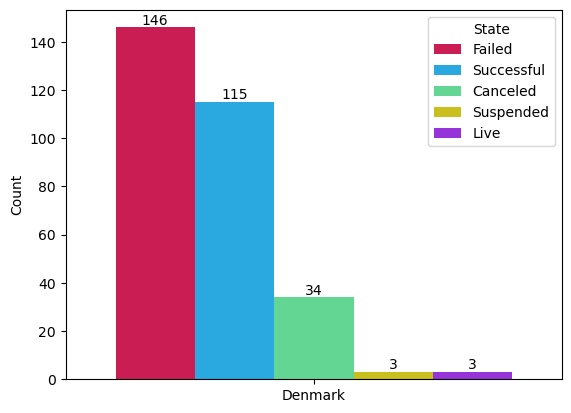

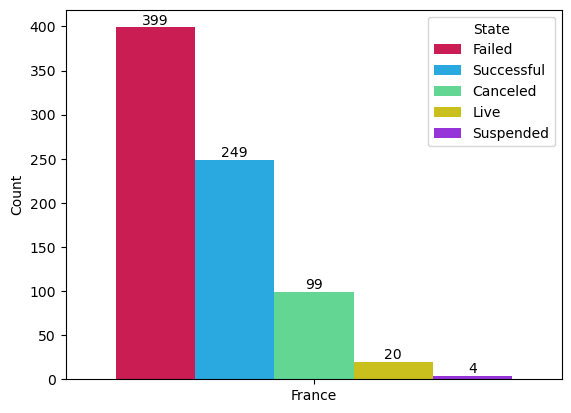

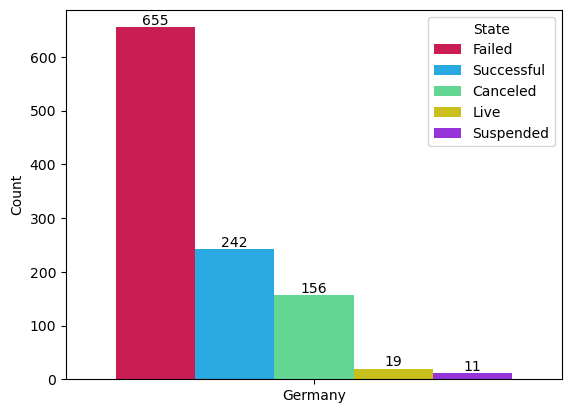

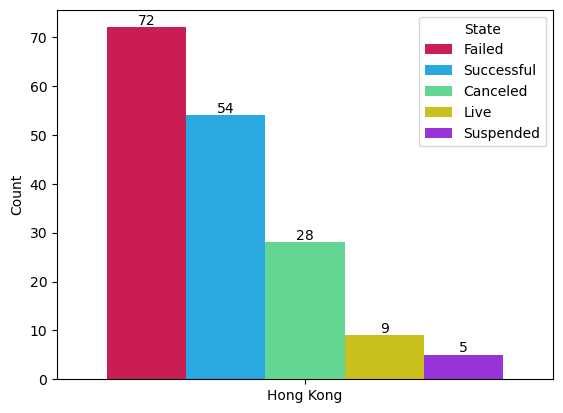

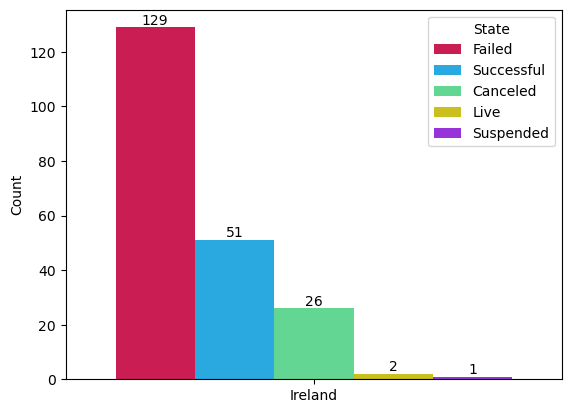

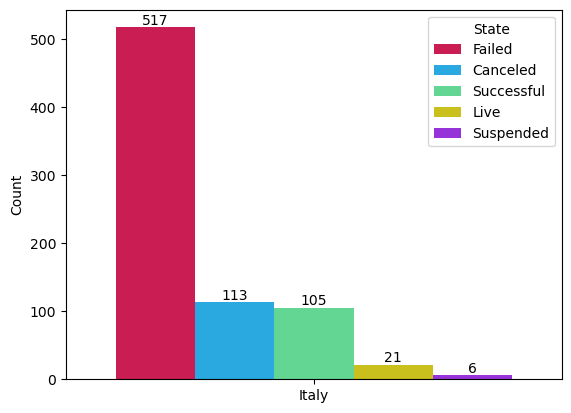

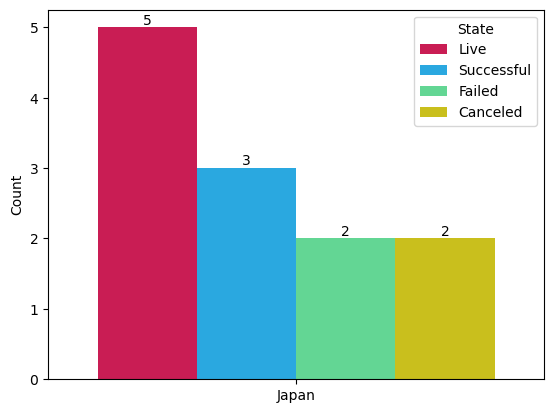

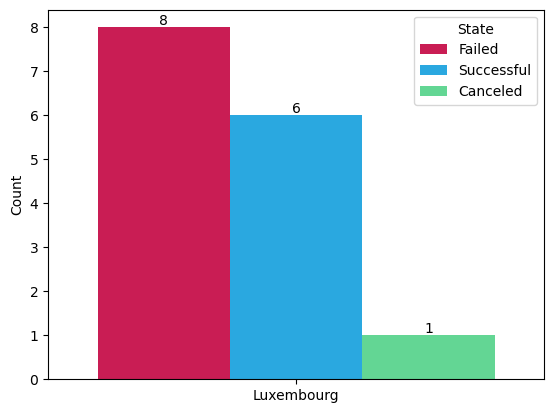

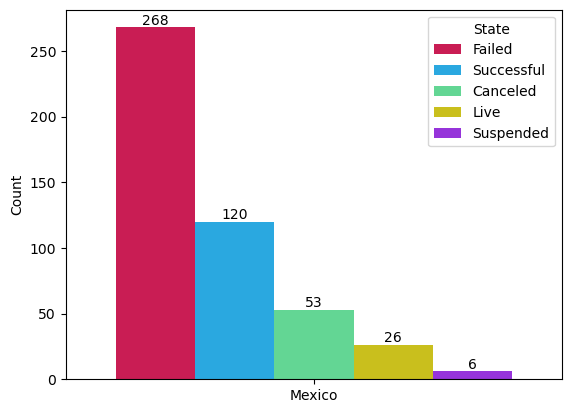

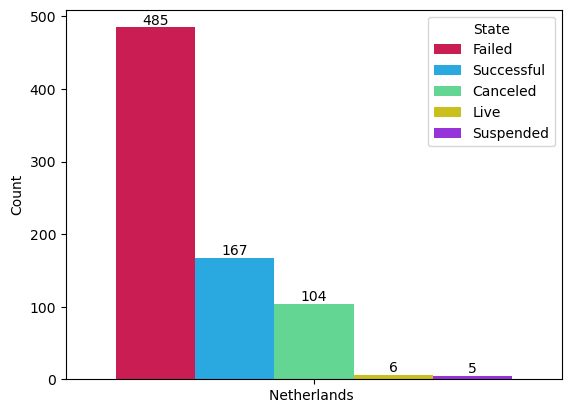

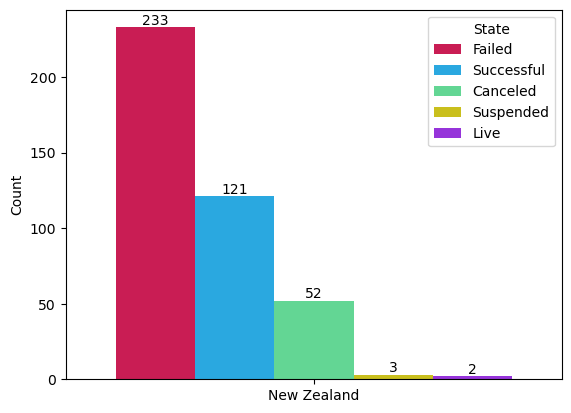

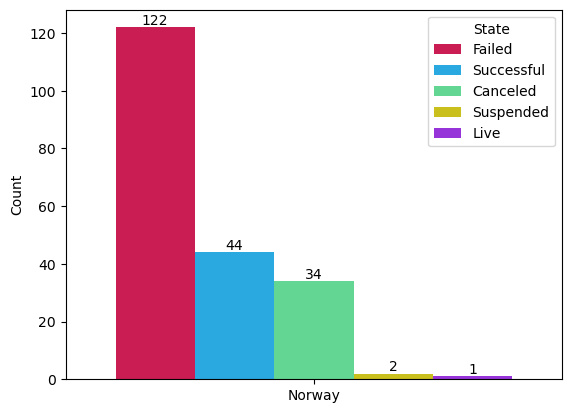

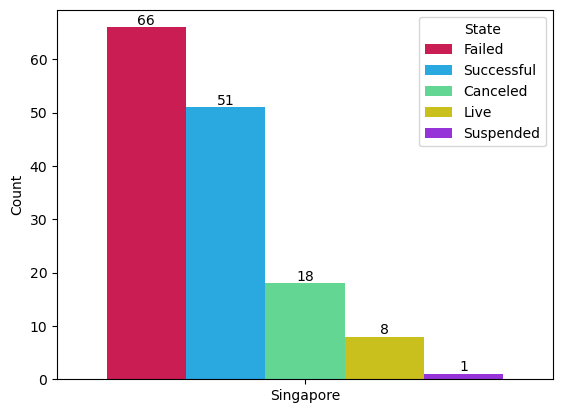

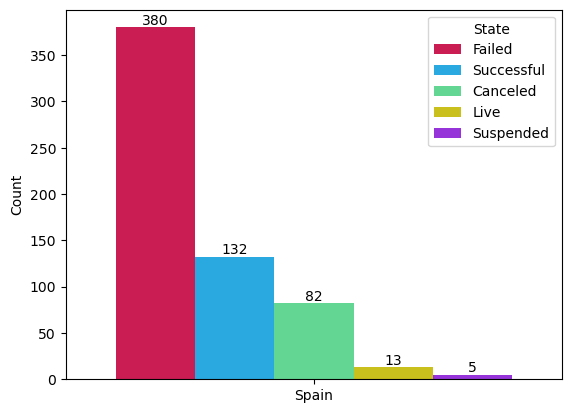

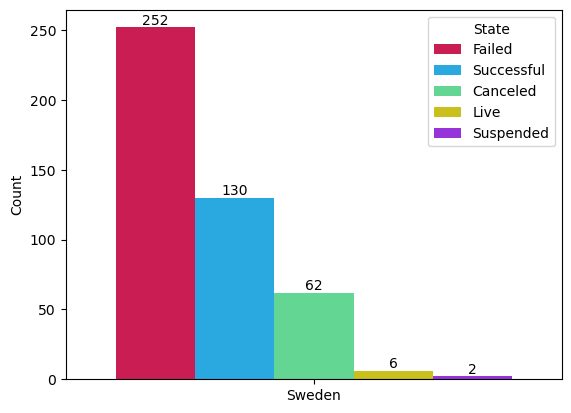

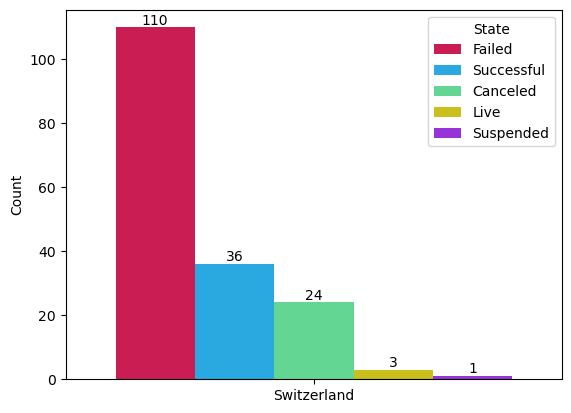

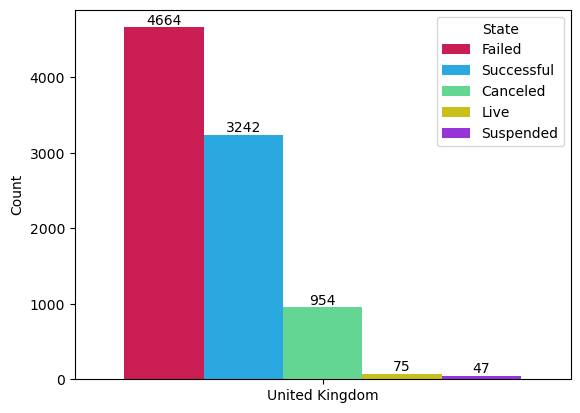

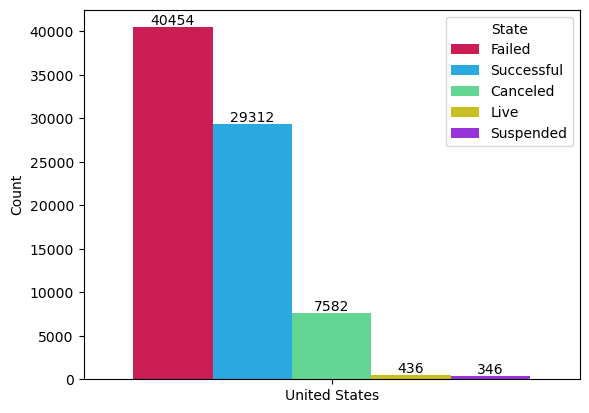

In [237]:
palette = ['#e60049', '#0bb4ff', '#50e991', '#e6d800', '#9b19f5']
plt.title("State distribution between country")
for i in temp['Country'].sort_values().unique():
    ax = sns.barplot(data=temp[temp['Country']==i],x='Country',y='State/Country',hue='State',palette=palette)
    for container in ax.containers:
        ax.bar_label(container, fmt='%d')
    ax.set(xlabel="",ylabel="Count")
    plt.show()

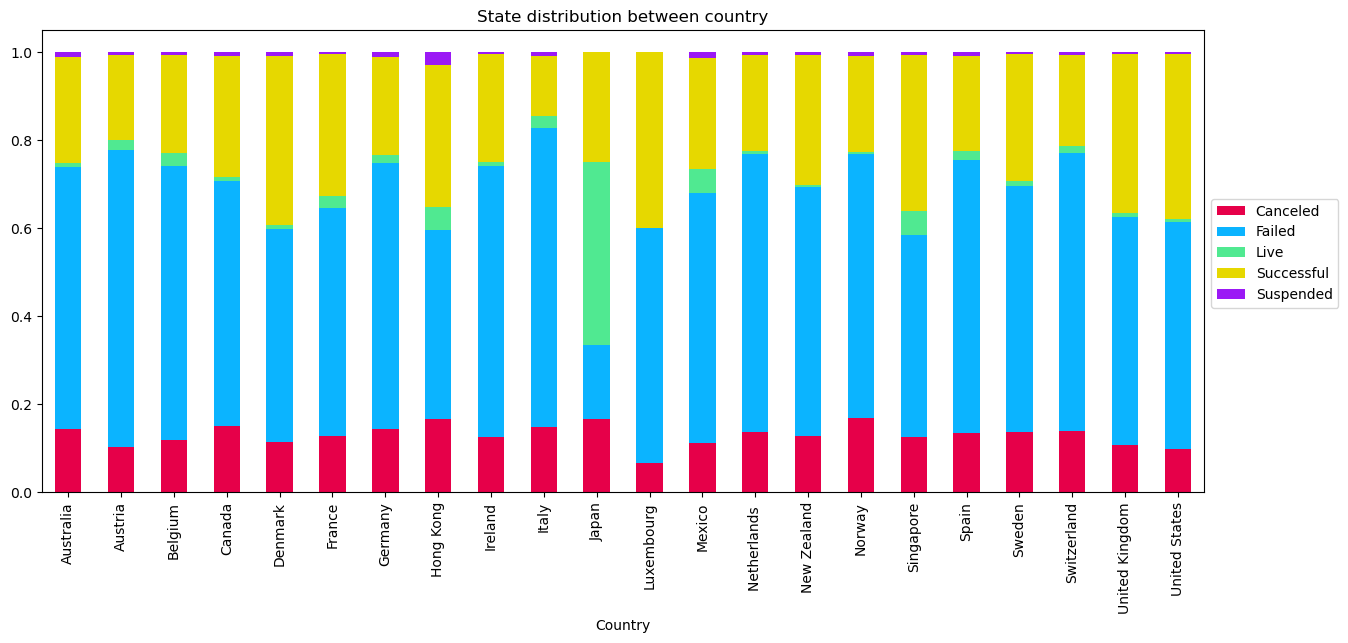

In [238]:
temp = temp.pivot_table(index='Country',columns='State',values='State/Country').fillna(0).apply(lambda x: x/x.sum(),axis=1)
temp.plot.bar(stacked=True,figsize=(15,6),color=palette).legend(bbox_to_anchor=(1,0.65))
plt.title("State distribution between country")
plt.show()

### State distribution in each category

In [239]:
temp = sample.copy()
temp['State/Category']= 0
temp = temp.groupby(['Category','State'])['State/Category'].count().reset_index().sort_values('State/Category',ascending=False)
temp

Category       State  State/Category
31  Film & Video      Failed            8738
53         Music  Successful            6409
33  Film & Video  Successful            6246
61    Publishing      Failed            6003
51         Music      Failed            5872
..           ...         ...             ...
17         Dance        Live               5
9         Comics   Suspended               5
19         Dance   Suspended               5
47    Journalism        Live               5
74       Theater   Suspended               5

[75 rows x 3 columns]

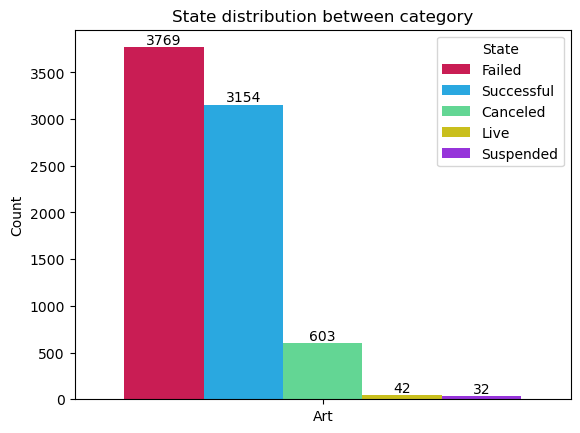

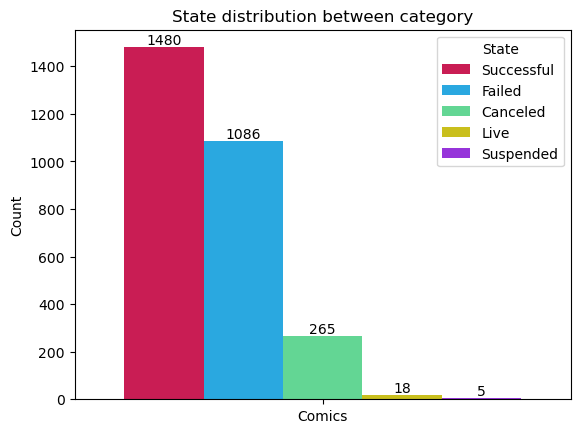

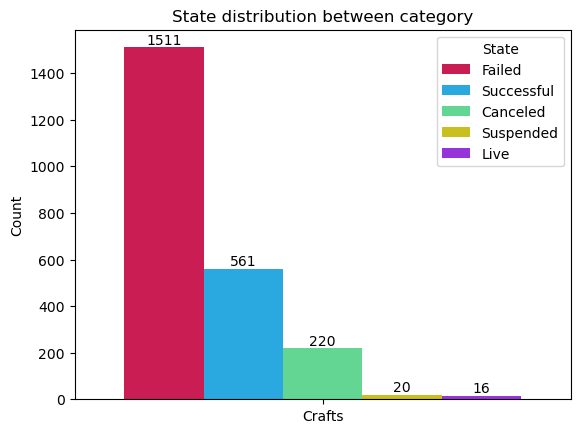

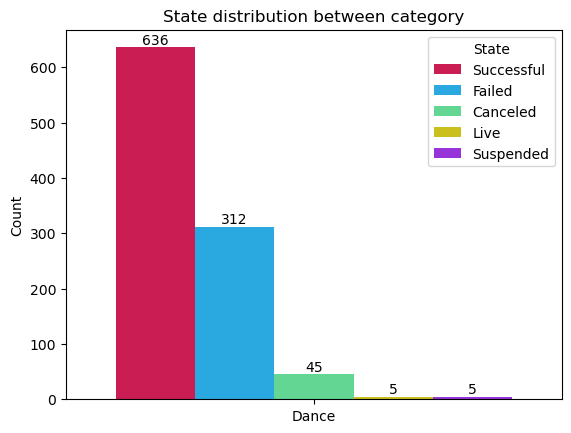

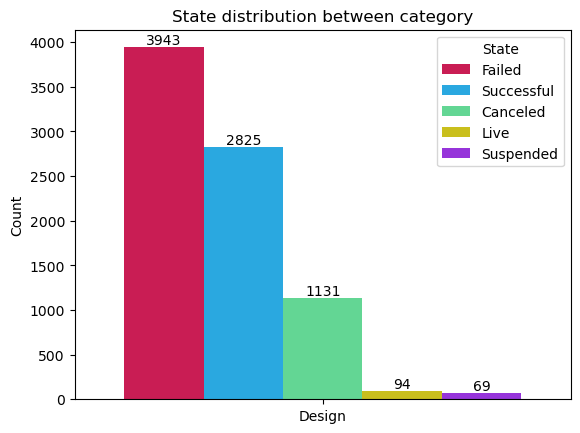

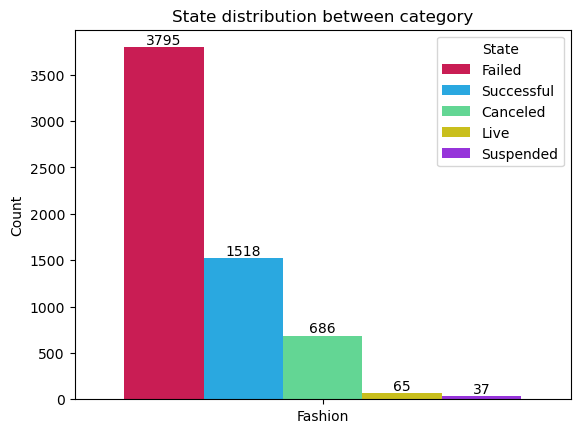

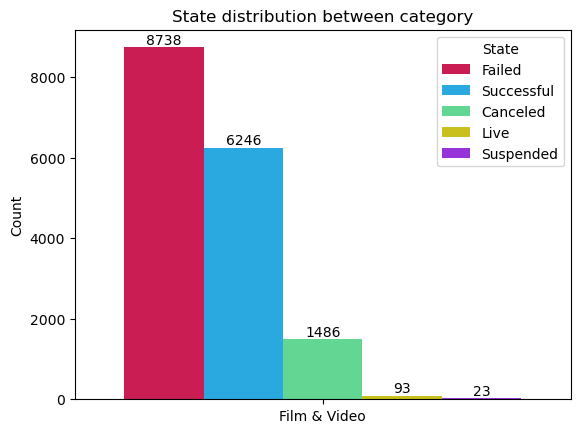

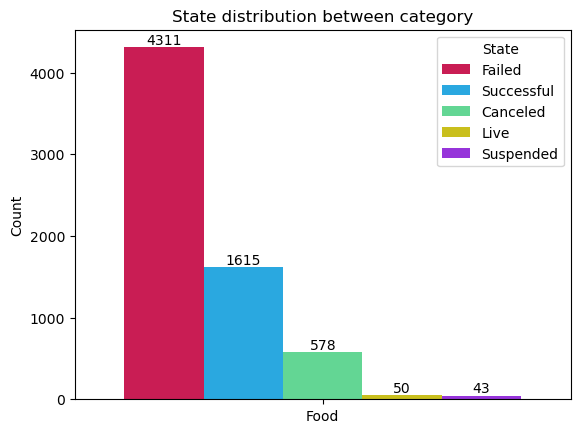

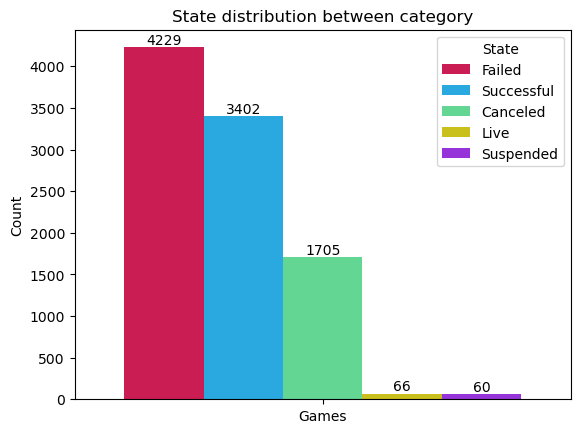

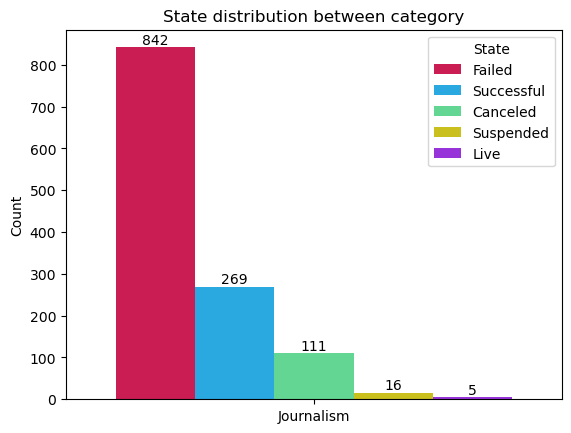

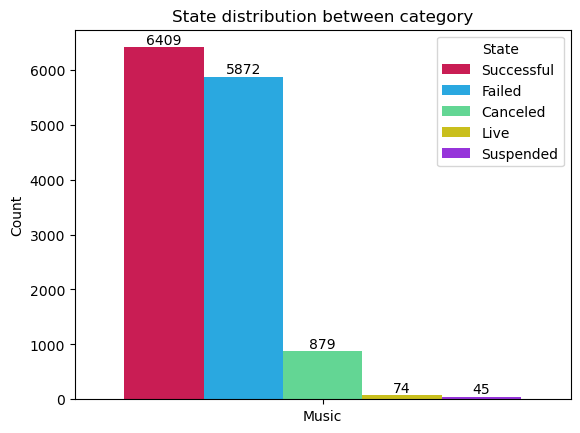

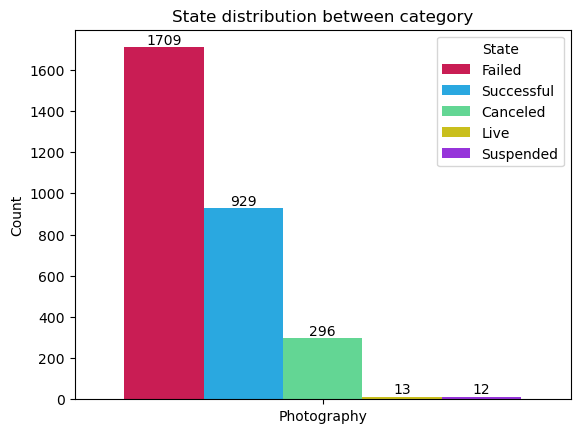

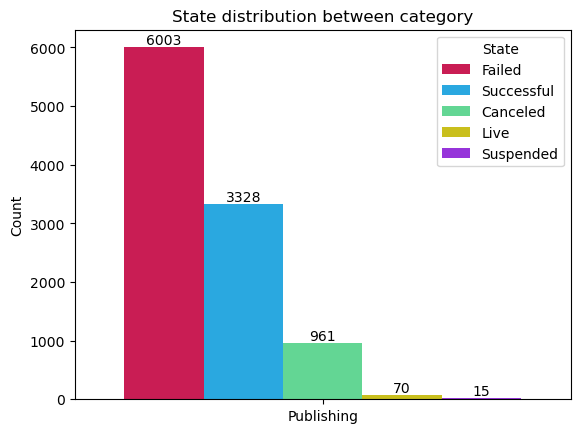

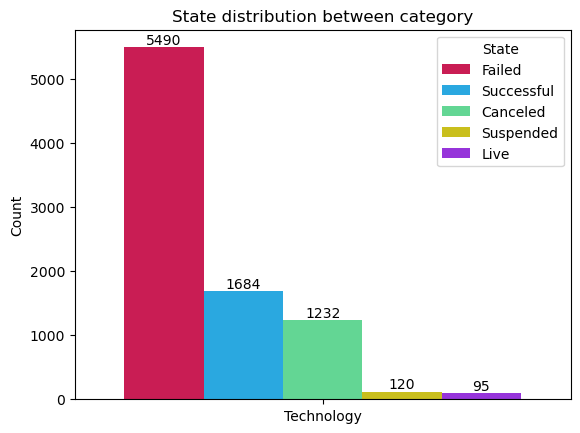

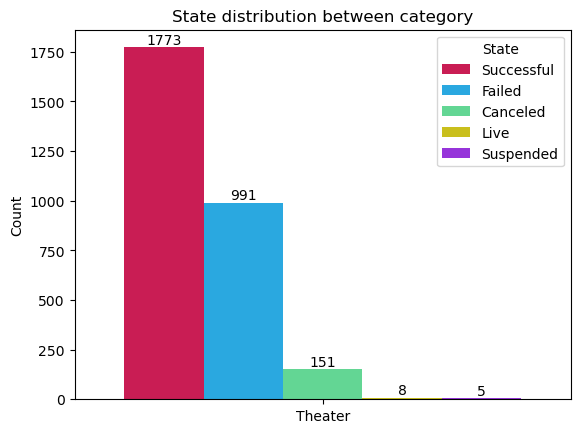

In [240]:
for i in temp['Category'].sort_values().unique():
    ax = sns.barplot(data=temp[temp['Category']==i],x='Category',y='State/Category',hue='State',palette=palette)
    for container in ax.containers:
        ax.bar_label(container, fmt='%d')
    ax.set(xlabel="",ylabel="Count")
    plt.title("State distribution between category")
    plt.show()

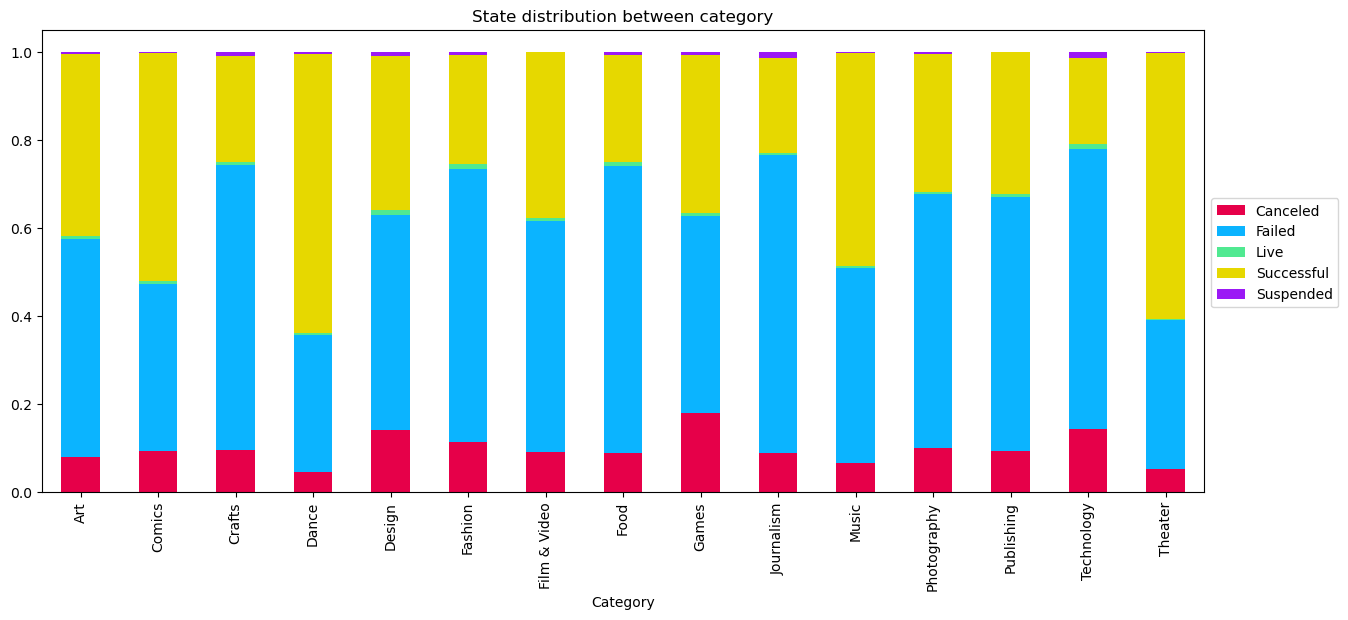

In [241]:
temp = temp.pivot_table(index='Category',columns='State',values='State/Category').fillna(0).apply(lambda x: x/x.sum(),axis=1)
temp.plot.bar(stacked=True,figsize=(15,6),color=palette).legend(bbox_to_anchor=(1,0.65))
plt.title("State distribution between category")
plt.show()

### State distribution in each goal (log scale bin)

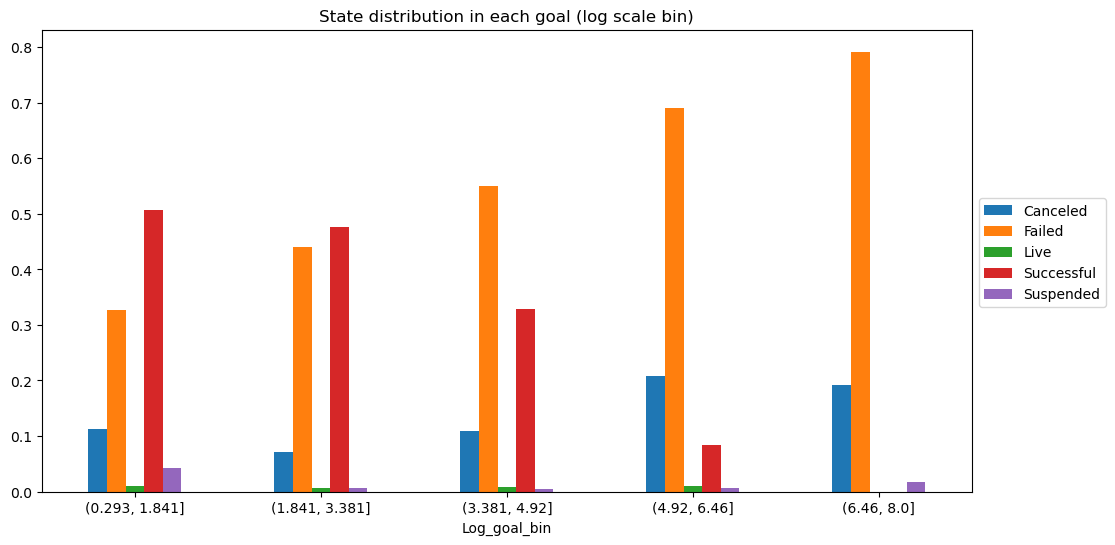

In [242]:
temp = sample.copy()
temp['Log_goal'] = np.log10(temp['Goal']+1)
temp['Log_goal_bin'] = pd.cut(temp['Log_goal'],bins=5)

state_goal = pd.crosstab(index=temp['Log_goal_bin'],columns=temp['State'])
state_goal = state_goal.apply(lambda x:x/x.sum(),axis=1)
ax = state_goal.plot.bar(stacked=False,figsize=(12,6))
ax.legend(bbox_to_anchor=(1, 0.65))
plt.xticks(rotation=0)
plt.title("State distribution in each goal (log scale bin)")
plt.show()

### Average pledged by Category

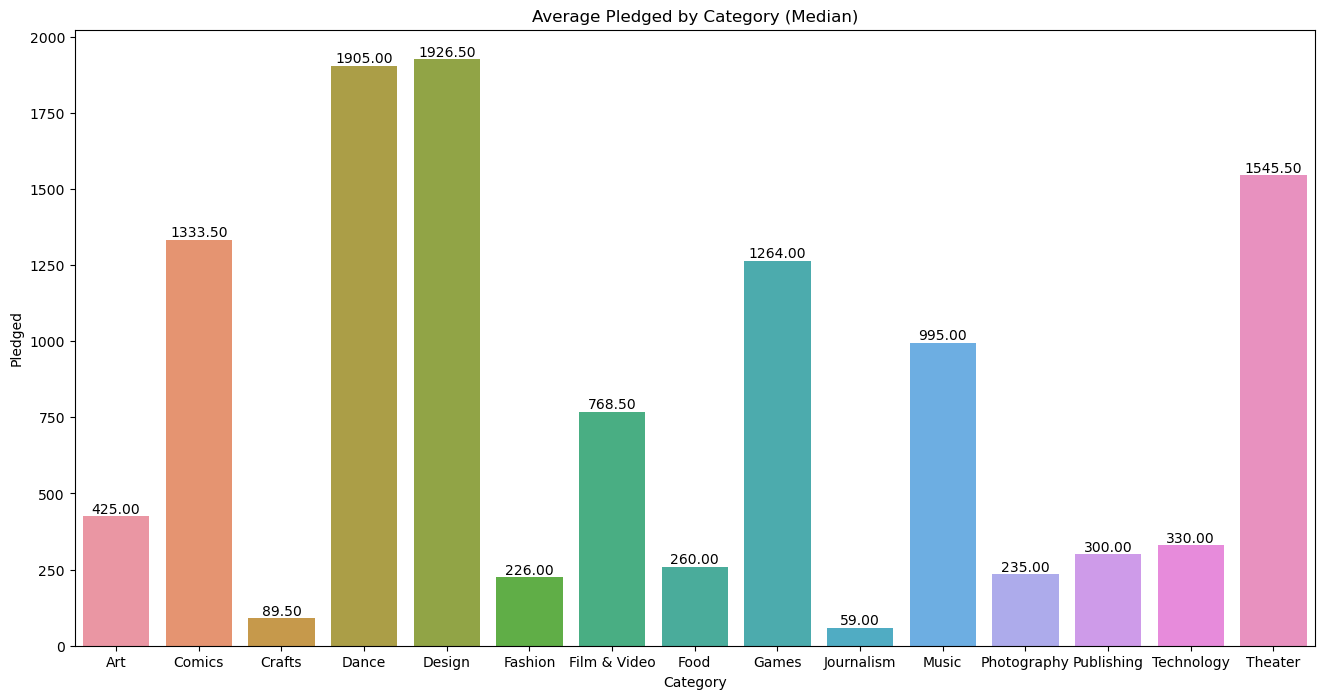

In [243]:
avg_pledge_category = sample.groupby("Category")["Pledged"].median().reset_index()
fig = plt.figure(figsize=(16, 8))
ax = sns.barplot(data= avg_pledge_category, x="Category", y="Pledged")
plt.title("Average Pledged by Category (Median)")
plt.xlabel("Category")
plt.ylabel("Pledged")
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')
plt.show()

### Crowdfunding interval distribution between each category with success state.

In [244]:
success = temp[temp['State']=='Successful']

res = pd.DataFrame(success.groupby(['Category','Log_goal_bin'])['Interval'].mean().fillna(-1)).apply(lambda x: np.ceil(x)).reset_index()
res

Category    Log_goal_bin  Interval
0       Art  (0.293, 1.841]      26.0
1       Art  (1.841, 3.381]      28.0
2       Art   (3.381, 4.92]      32.0
3       Art    (4.92, 6.46]      37.0
4       Art     (6.46, 8.0]      -1.0
..      ...             ...       ...
70  Theater  (0.293, 1.841]      32.0
71  Theater  (1.841, 3.381]      29.0
72  Theater   (3.381, 4.92]      32.0
73  Theater    (4.92, 6.46]      39.0
74  Theater     (6.46, 8.0]      -1.0

[75 rows x 3 columns]

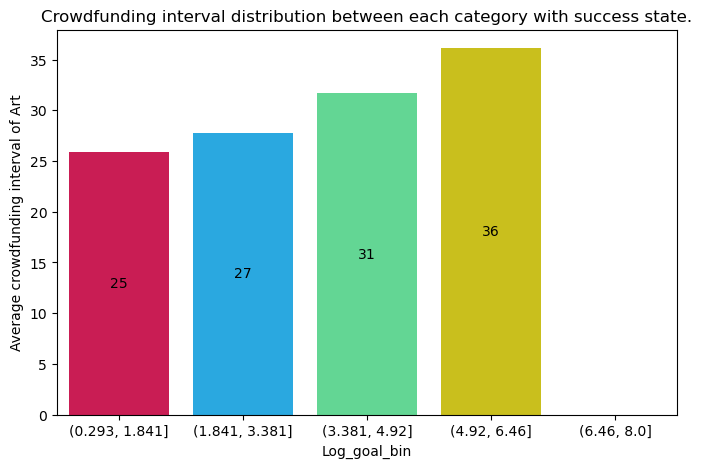

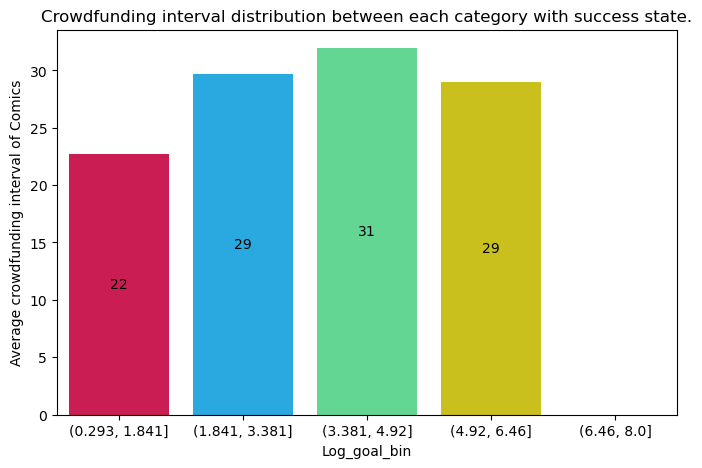

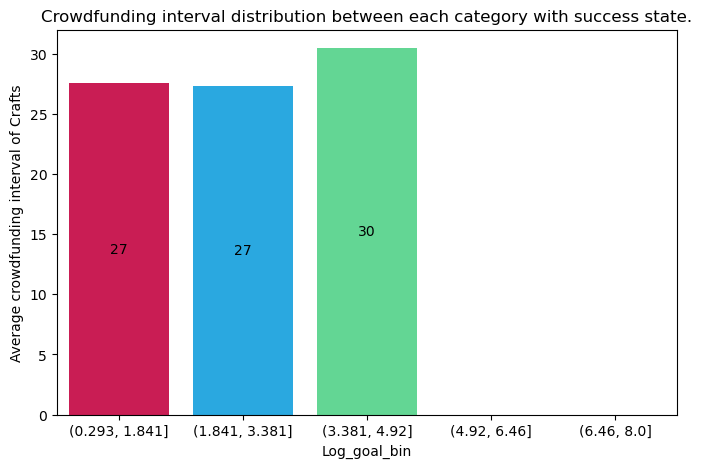

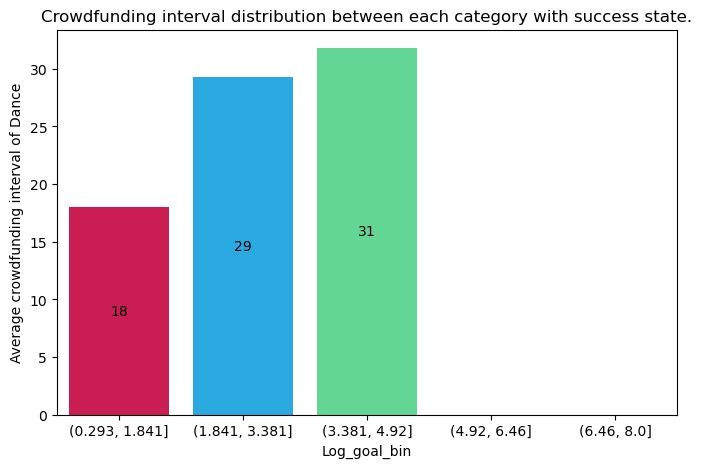

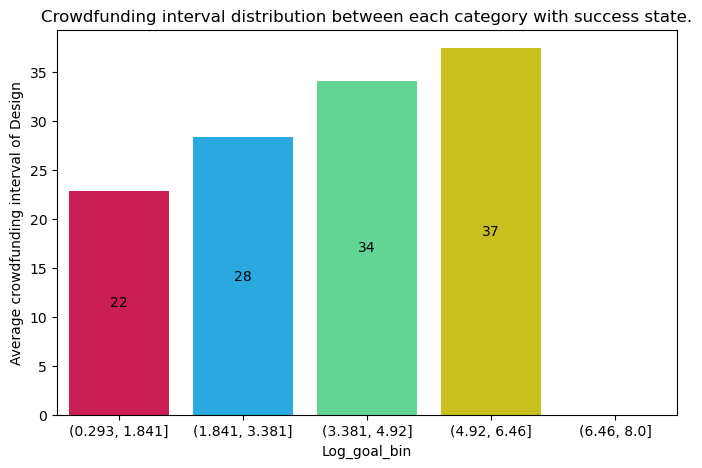

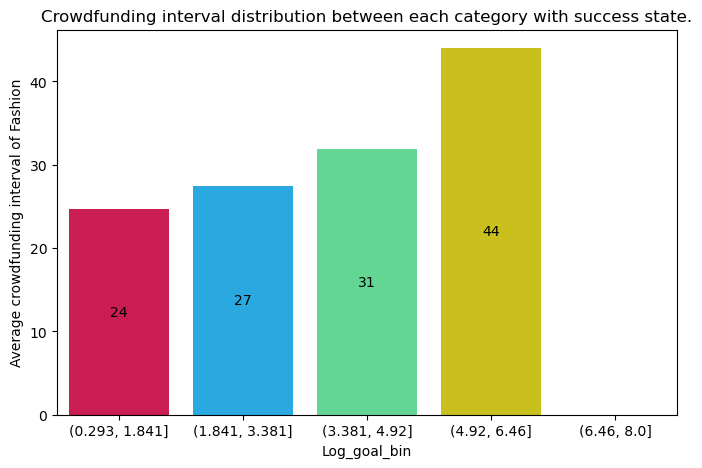

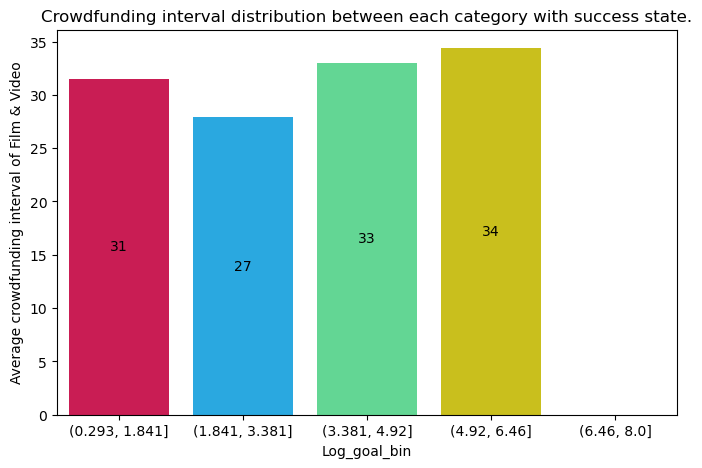

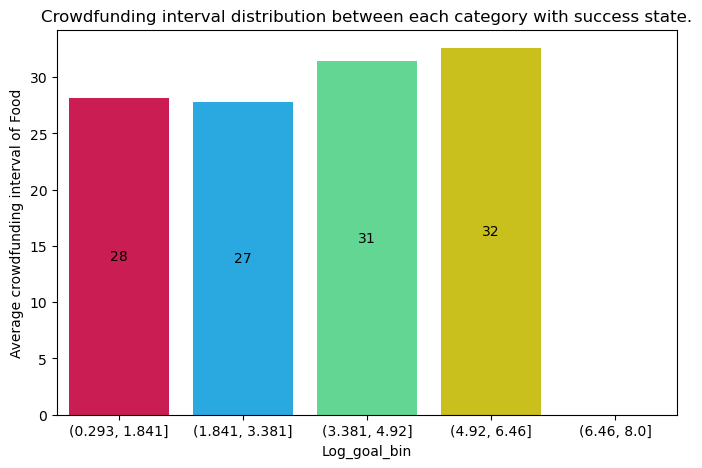

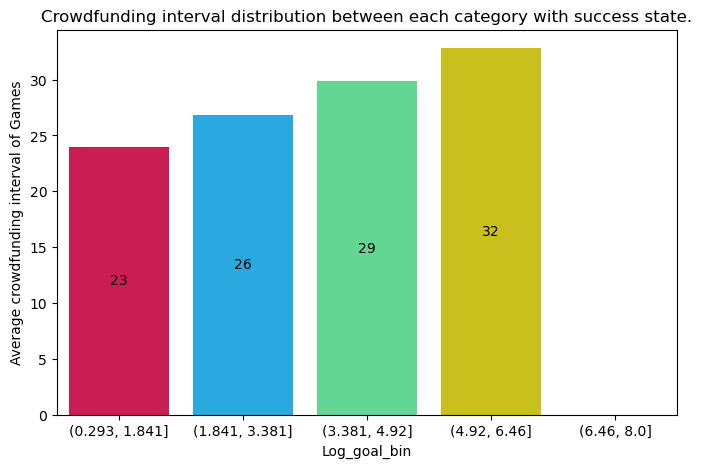

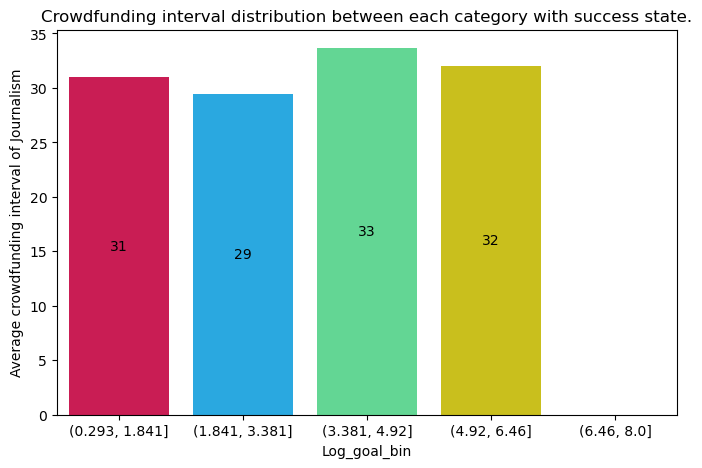

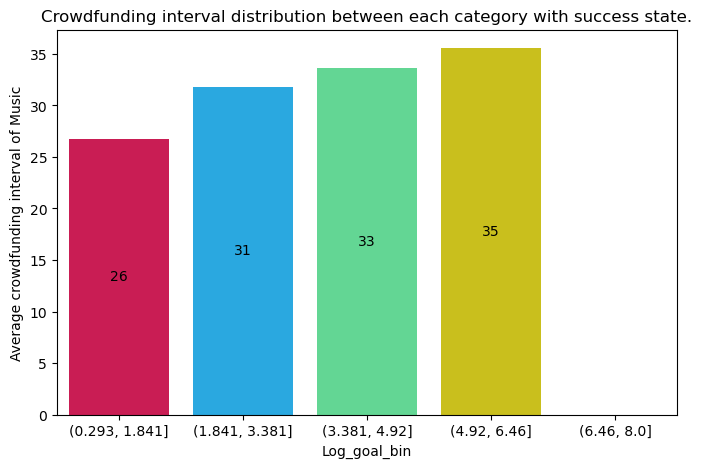

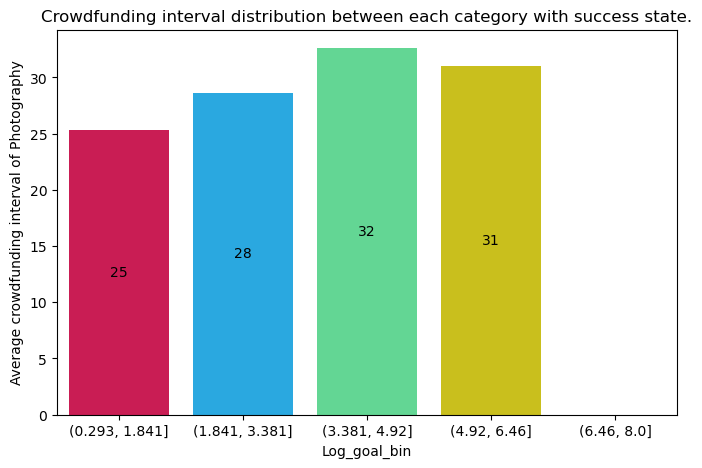

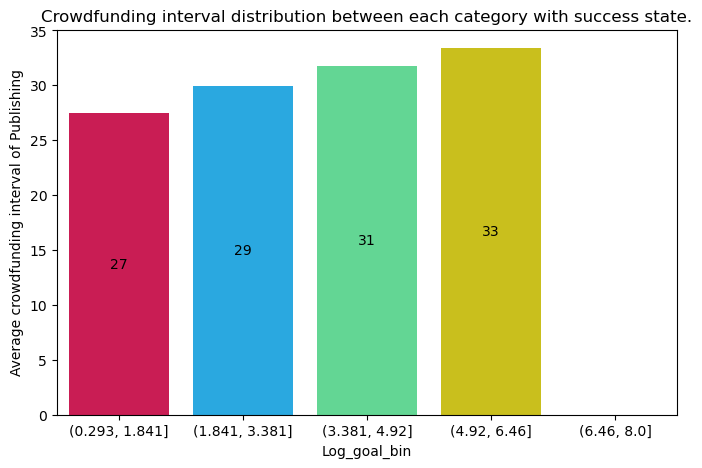

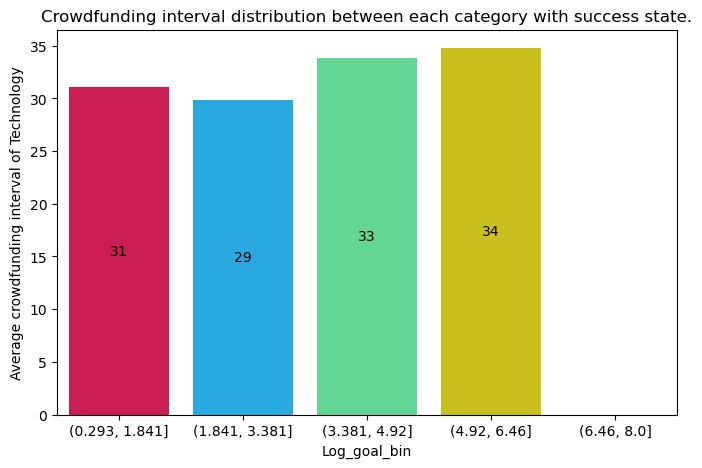

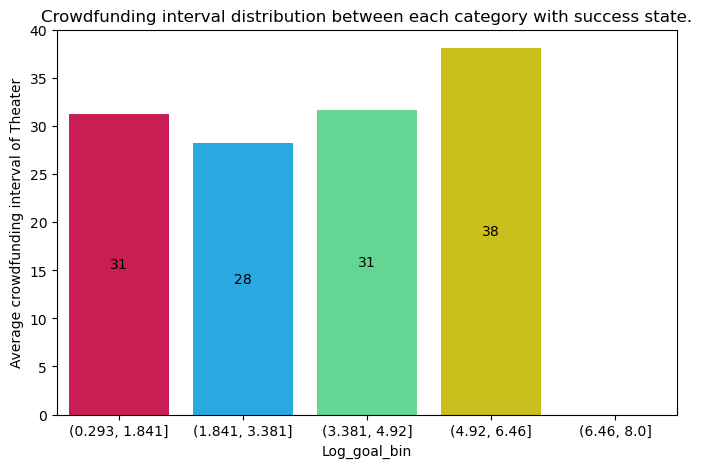

In [245]:
for i in success['Category'].sort_values().unique():
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(data=success[success['Category']==i],x='Log_goal_bin',y='Interval',palette=palette,ci=None)
    ax.set(ylabel=f"Average crowdfunding interval of {i}")
    for container in ax.containers:
        ax.bar_label(container, fmt='%d',label_type='center')
    plt.title("Crowdfunding interval distribution between each category with success state.")
    plt.show()

In [246]:
# df.sample(1000)["Backers"].hist(edgecolor="black")
# plt.show()

In [247]:
# df["Backers"].max()

In [248]:
# sns.countplot(data = df, x = "State")
# plt.show()

In [249]:
# Show ratio

# df['Goal_bin'] = pd.qcut(df['Goal'],q=5)
# stateByGoal = pd.crosstab(index = df['Goal_bin'], columns = df['State']).apply(lambda x: x/sum(x), axis=1)
# stateByGoal.plot.bar(stacked = False).legend(bbox_to_anchor=(1.2,0.5))
# plt.show()


# Show count
# df_green = df
# df_green['Goal_bin'] = pd.qcut(df_green['Goal'], q=5)
# stateByGoal = pd.crosstab(index=df_green['Goal_bin'], columns=df_green['State'])
# ax = stateByGoal.plot.bar(stacked=False)
# ax.set_ylabel('Count')
# ax.legend(bbox_to_anchor=(1.2, 0.5))
# plt.show()

In [250]:
# df_green['Goal_bin'] = pd.qcut(df['Goal'], q=5)
# stateByGoal = pd.crosstab(index=df_green['Goal_bin'], columns=df_green['State'])
# meanBackers = df_green.groupby('Goal_bin')['Backers'].mean()
# pd.DataFrame(meanBackers)
# ax = meanBackers.plot.bar(stacked = False)
# ax.set_ylabel('Average backers')
# ax.legend(bbox_to_anchor=(1.2, 0.5))
# plt.show()

## Modeling implementation

### Prepared data for model implementation

In [251]:
sample_cat_country = pd.get_dummies(sample.Country)
sample_cat_sub = pd.get_dummies(sample.Subcategory)
sample_cat_cate = pd.get_dummies(sample.Category)
kickstart_num = sample.select_dtypes("number")
kickstart_ob = sample.select_dtypes("object")

In [252]:
scaler = StandardScaler()
kickstart_num = pd.DataFrame(scaler.fit_transform(kickstart_num), columns=kickstart_num.columns)

In [253]:
prepared_kickstart = pd.concat([sample_cat_cate.reset_index(drop=True), 
                                sample_cat_country.reset_index(drop=True), 
                                sample_cat_sub.reset_index(drop=True),
                                kickstart_num.drop(columns=["Pledged", "Backers"]).\
                                    reset_index(drop=True), 
                                kickstart_ob.State.reset_index(drop=True) ], axis=1)

In [254]:
kickstart_train, kickstart_test = train_test_split( prepared_kickstart, train_size=0.7)

### Hyperparameter tuning

In [255]:
para = DecisionTreeClassifier() # here we use 
para.get_params() # To see all parameter of Decision tree

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [256]:
paraDist = {
    "max_depth": np.arange(6, 15),
    "criterion" :["gini", "entropy"],
}

In [257]:
grid = gsv(para, paraDist, cv=5)
grid.fit(kickstart_train.drop(columns="State"), kickstart_train["State"])

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 6,  7,  8,  9, 10, 11, 12, 13, 14])})

In [258]:
pd.DataFrame(grid.cv_results_)[["param_max_depth", "param_criterion", "mean_test_score"]]

param_max_depth param_criterion  mean_test_score
0                6            gini         0.569343
1                7            gini         0.574829
2                8            gini         0.578300
3                9            gini         0.578571
4               10            gini         0.577929
5               11            gini         0.579343
6               12            gini         0.577614
7               13            gini         0.576657
8               14            gini         0.576457
9                6         entropy         0.568371
10               7         entropy         0.571843
11               8         entropy         0.576614
12               9         entropy         0.577800
13              10         entropy         0.577329
14              11         entropy         0.577529
15              12         entropy         0.576371
16              13         entropy         0.575014
17              14         entropy         0.572929

In [259]:
print("Best score:", grid.best_score_)
print("Best parameter:", grid.best_params_)

Best score: 0.5793428571428572
Best parameter: {'criterion': 'gini', 'max_depth': 11}


### Using Decision tree for modeling

In [260]:
tree = DecisionTreeClassifier(max_depth = grid.best_params_["max_depth"], criterion=grid.best_params_["criterion"])
tree.fit(kickstart_train.drop(columns = ["State"]), kickstart_train["State"] )

DecisionTreeClassifier(max_depth=11)

In [261]:
from six import StringIO 
from IPython.display import Image 
from sklearn.tree import export_graphviz
import pydotplus 

dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,
                rotate=True,
                class_names=kickstart_train["State"].unique())

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('tree.png')
Image(graph.create_png())

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.481889 to fit

(process:13608): GLib-GIO-WARNING **: 22:20:16.696: Unexpectedly, UWP app `Microsoft.ScreenSketch_11.2303.17.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.ScreenSketch_8wekyb3d8bbwe!App') supports 29 extensions but has no verbs

(process:13608): GLib-GIO-WARNING **: 22:20:16.718: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.6.0.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.481889 to fit

(process:19248): GLib-GIO-WARNING **: 22:20:22.050: Unexpectedly, UWP app `Microsoft.ScreenSketch_11.2303.17.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.ScreenSketch_8wekyb3d8bbwe!App') supports 29 extensions but has no verbs

(process:19248): GLib-GIO-WARNING **: 22:20:22.070: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.6.0.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') sup

In [262]:
feature = kickstart_train.drop(columns = ["State"])
pd.DataFrame(dict(Feature=feature.columns,
                  Value=tree.feature_importances_))\
  .sort_values(by='Value', ascending=False).head(20)
# To see which attribute is informative (only first 20)

Feature     Value
196             Goal  0.391663
197         Interval  0.214778
173   Tabletop Games  0.067911
10             Music  0.043895
14           Theater  0.040491
105          Hip-Hop  0.032827
166           Shorts  0.027513
1             Comics  0.019338
3              Dance  0.015987
36     United States  0.014168
45              Apps  0.008077
4             Design  0.007783
35    United Kingdom  0.006379
73             Dance  0.006318
7               Food  0.006150
109       Indie Rock  0.006088
18            Canada  0.004995
67    Country & Folk  0.003617
15         Australia  0.003488
60   Classical Music  0.003429

In [263]:
result = pd.concat([pd.DataFrame(kickstart_test.State.reset_index(drop=True)),
                    pd.DataFrame(tree.predict(kickstart_test.drop(columns="State")), 
                                 columns=["predict_state"]).reset_index(drop=True)]
                    , axis=1)
result 


State predict_state
0          Failed        Failed
1        Canceled        Failed
2      Successful        Failed
3          Failed        Failed
4        Canceled        Failed
...           ...           ...
29995      Failed        Failed
29996  Successful    Successful
29997  Successful        Failed
29998  Successful        Failed
29999    Canceled      Canceled

[30000 rows x 2 columns]

In [264]:
compare = result.loc[result.State == result.predict_state]
compare

State predict_state
0          Failed        Failed
3          Failed        Failed
5          Failed        Failed
6      Successful    Successful
8      Successful    Successful
...           ...           ...
29993      Failed        Failed
29994      Failed        Failed
29995      Failed        Failed
29996  Successful    Successful
29999    Canceled      Canceled

[17466 rows x 2 columns]

In [265]:
print(len(compare.index), "of the records are predicted correctly.")

17466 of the records are predicted correctly.


### Classification report

In [266]:
classifiaction_rep = tree.predict(kickstart_test.drop(columns="State"))
print(classification_report(y_true=kickstart_test['State'].values, y_pred = classifiaction_rep))
# To see the confusion matrix from modeling result

              precision    recall  f1-score   support

    Canceled       0.24      0.02      0.03      3060
      Failed       0.58      0.85      0.69     15827
        Live       0.14      0.00      0.01       207
  Successful       0.58      0.37      0.45     10755
   Suspended       0.00      0.00      0.00       151

    accuracy                           0.58     30000
   macro avg       0.31      0.25      0.24     30000
weighted avg       0.54      0.58      0.53     30000

